# Simple Autoencoder

In [1]:
# Author: Vivian Wong
# Modified from Code by Sherlock Liao available at https://github.com/L1aoXingyu/pytorch-beginner?files=1

import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np

In [2]:
def load_meltpool_dataset():
    root = './data/meltpool/Meltpool_Camera_(partial)'
    batch_size = 128
    
    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.CenterCrop(70),
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    dataset = torchvision.datasets.ImageFolder(root=root, transform=transform)
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True
    )
    return dataset, dataloader

def load_MNIST_dataset():
    batch_size = 128
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    dataset = MNIST('./data', transform=transform, download=False)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataset, dataloader

In [3]:
# autoencoder
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, 12), 
            nn.ReLU(True), 
            nn.Linear(12, 2))
        self.decoder = nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, 28 * 28), 
            nn.Tanh())

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [4]:
if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')
    
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

num_epochs = 30
learning_rate = 1e-3

dataset, dataloader = load_meltpool_dataset()
# dataset, dataloader = load_MNIST_dataset()

using device: cpu


In [14]:
def plot2D_with_labels(XY, labels, num_labels=9):
    if type(XY)==torch.Tensor:
        XY = XY.numpy()
    plt.cla()
    X, Y = XY[:, 0], XY[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / num_labels)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.show(); plt.pause(0.01)

In [99]:
def plot3D_with_labels(XYZ, labels, num_labels=9):
    if type(XYZ)==torch.Tensor:
        XYZ = XYZ.numpy()
    fig = plt.figure(2); ax = Axes3D(fig)
    X, Y, Z = XYZ[:, 0].numpy(), XYZ[:, 1].numpy(), XYZ[:, 2].numpy() # put encoded data to [x,y,z]
    digits = train_data.train_labels[:200].numpy()
    for x, y, z, s in zip(X, Y, Z, digits):
        c = cm.rainbow(int(255*s/num_labels)); ax.text(x, y, z, s, backgroundcolor=c)
    ax.set_xlim(X.min(), X.max()); ax.set_ylim(Y.min(), Y.max()); ax.set_zlim(Z.min(), Z.max())
    plt.show()

In [110]:
def plot2D_with_thumbnails(XY, labels, thumbnails, num_labels = 9, cmap = None):
    def getThumbnail(path):
        return OffsetImage(plt.imread(path), zoom=0.5, cmap=cmap)

    if type(XY)==torch.Tensor:
        XY = XY.numpy()
#     plt.cla()
    X, Y = XY[:, 0], XY[:, 1]
    fig, ax = plt.subplots(figsize=(20,20))
    ax.scatter(X, Y) 
    for x, y, s, path in zip(X, Y, labels, thumbnails):
        ab = AnnotationBbox(getThumbnail(path), (x, y), frameon=True)
        ax.add_artist(ab)
#         c = cm.rainbow(int(255 * s / num_labels))
#         plt.text(x, y, s, backgroundcolor=c, fontsize=9)
#         plt.scatter(x, y, marker=path)
#     plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.show(); plt.pause(0.01)
    
  

In [7]:
# train autoencoder
model = autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=1e-5)

for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img).to(device)
        # ===================forward=====================
        encoded, decoded = model(img)
        loss = criterion(decoded, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.item()))
    if epoch % 10 == 0:
        pic = to_img(decoded.cpu().data)
        save_image(pic, './mlp_img/image_{}.png'.format(epoch))
        torch.save(model.state_dict(), './sim_autoencoder.pth')

epoch [1/30], loss:0.0072
epoch [2/30], loss:0.0142
epoch [3/30], loss:0.0160
epoch [4/30], loss:0.0086
epoch [5/30], loss:0.0088
epoch [6/30], loss:0.0044
epoch [7/30], loss:0.0044
epoch [8/30], loss:0.0054
epoch [9/30], loss:0.0046
epoch [10/30], loss:0.0045
epoch [11/30], loss:0.0066
epoch [12/30], loss:0.0060
epoch [13/30], loss:0.0049
epoch [14/30], loss:0.0039
epoch [15/30], loss:0.0054
epoch [16/30], loss:0.0051
epoch [17/30], loss:0.0055
epoch [18/30], loss:0.0081
epoch [19/30], loss:0.0040
epoch [20/30], loss:0.0051
epoch [21/30], loss:0.0052
epoch [22/30], loss:0.0035
epoch [23/30], loss:0.0031
epoch [24/30], loss:0.0033
epoch [25/30], loss:0.0024
epoch [26/30], loss:0.0036
epoch [27/30], loss:0.0053
epoch [28/30], loss:0.0039
epoch [29/30], loss:0.0038
epoch [30/30], loss:0.0047


In [8]:
torch.save(model.state_dict(), './sim_autoencoder.pth')

## View encoder output in 2D

In [122]:
# optional - load model state dict
model = autoencoder().to(device)
model.load_state_dict(torch.load('./sim_autoencoder.pth'))
model.eval()

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=12, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Tanh()
  )
)

### Meltpool

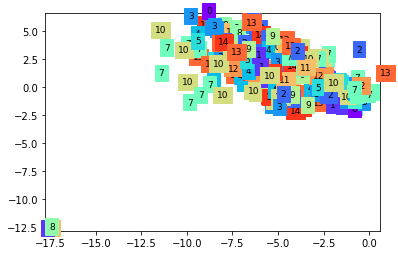

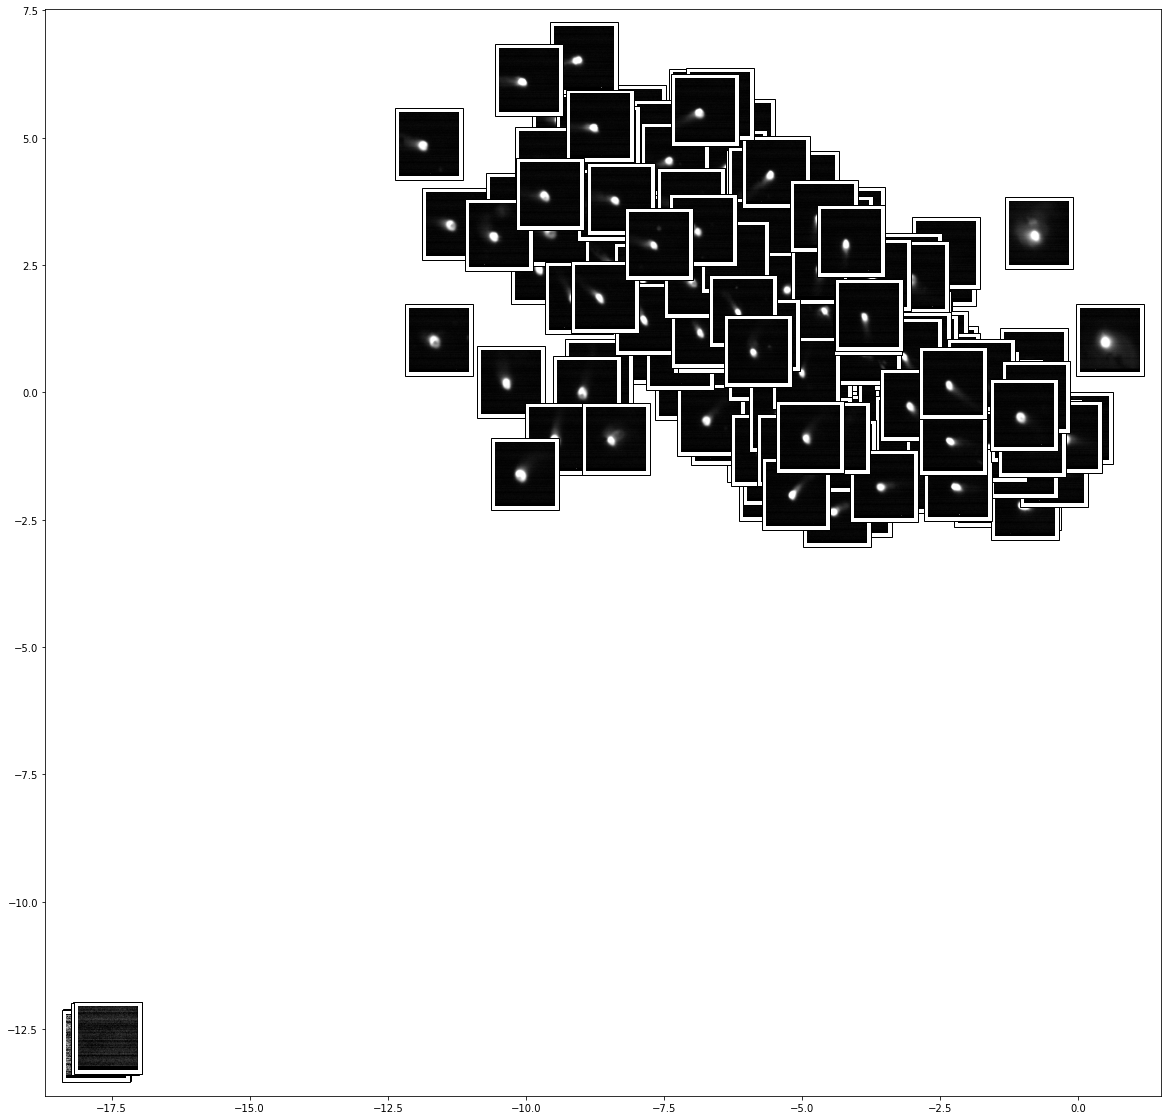

In [114]:
num_viewed = 200
random_seed = 1
indices = list(range(len(dataset)))
np.random.seed(random_seed)
np.random.shuffle(indices)
view_indices = indices[:num_viewed]
# initialize empty arrays/tensors
view_data = torch.empty(num_viewed, 28*28)
view_data_layers = np.random.randint(1, size=num_viewed)

view_thumbnails = [dataset.imgs[i][0] for i in view_indices]
for i in range(num_viewed):
    view_data[i,:] = dataset[view_indices[i]][0].view(-1,28*28)
    view_data_layers[i] = int(dataset[view_indices[i]][1])
    
encoded_data, _ = model(view_data)
# view encoder output in 2D
plot2D_with_labels(encoded_data.data, view_data_layers, num_labels = 15)
plot2D_with_thumbnails(encoded_data.data, view_data_layers, view_thumbnails, num_labels = 15, cmap = 'gray')

#### View encoder output using T-SNE

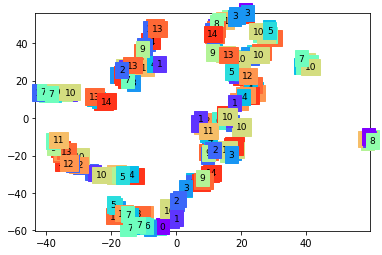

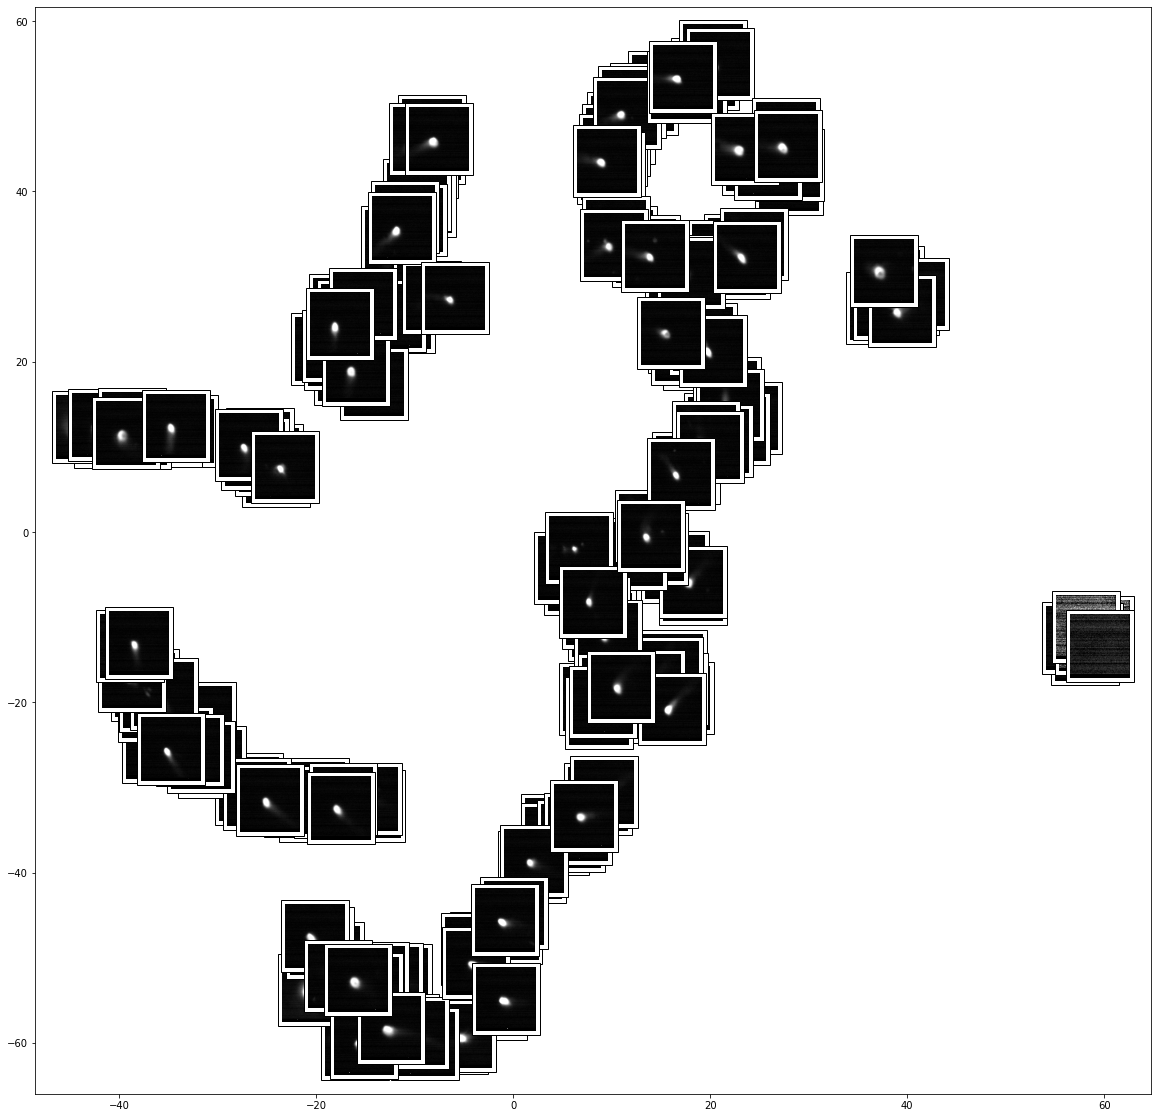

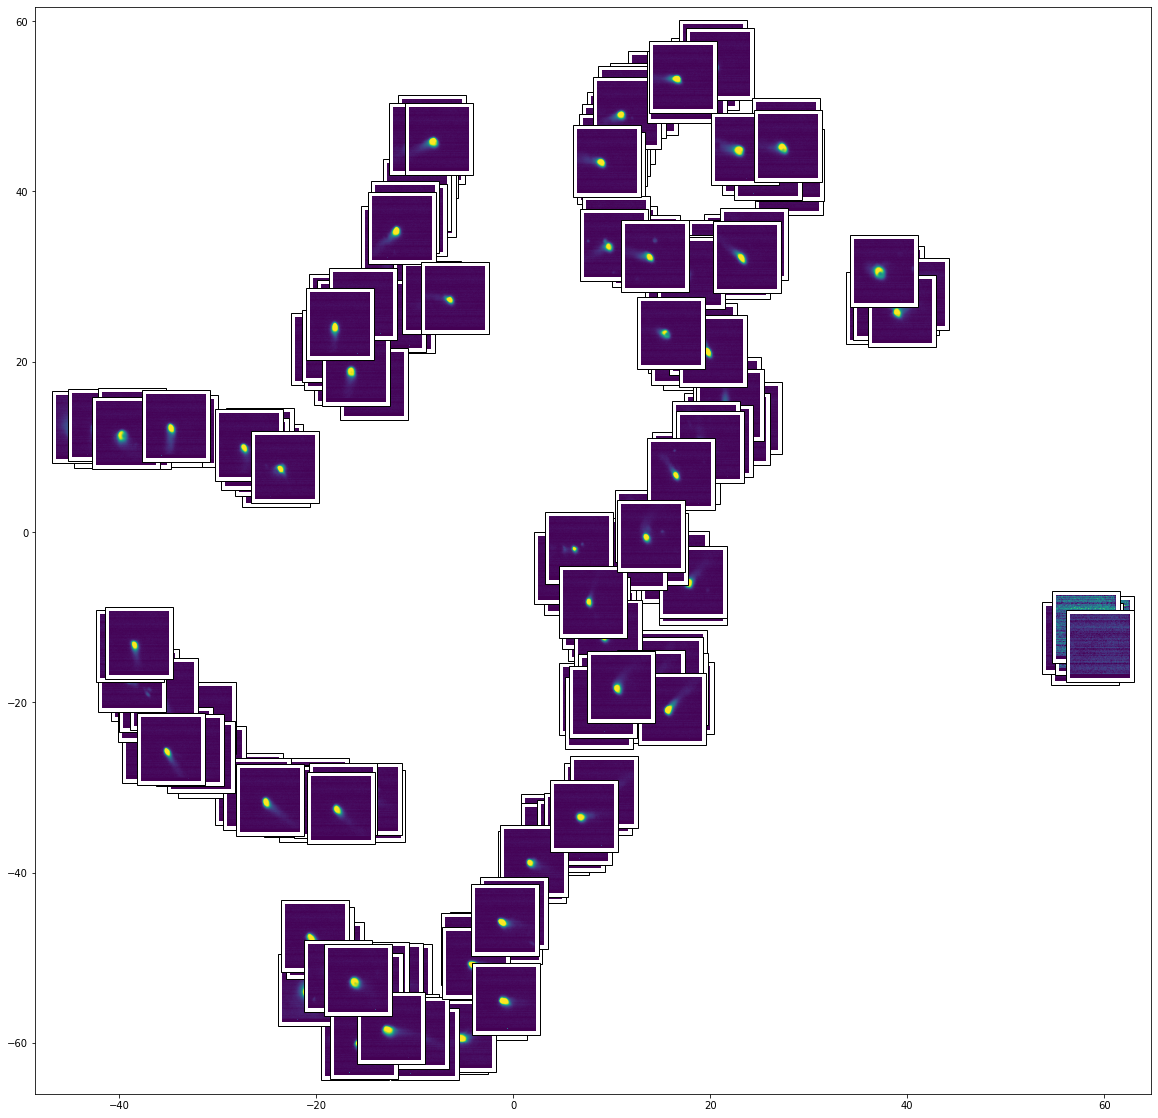

In [115]:
X = encoded_data.data.numpy()
X_embedded = TSNE(n_components=2, perplexity=5, init='pca', n_iter=1000).fit_transform(X)
X_embedded.shape

plot2D_with_labels(X_embedded, view_data_layers, num_labels = 15)
plot2D_with_thumbnails(X_embedded, view_data_layers, view_thumbnails, num_labels = 15, cmap='gray')

plot2D_with_thumbnails(X_embedded, view_data_layers, view_thumbnails, num_labels = 15)

### MNIST

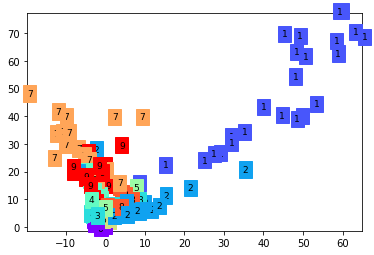

In [121]:
num_viewed = 200
view_indices = list(range(len(dataset)))
# initialize empty arrays/tensors
view_data = torch.empty(num_viewed, 28*28)
digits = np.random.randint(1, size=num_viewed)

for i in range(num_viewed):
    view_data[i,:] = dataset[view_indices[i]][0].view(-1,28*28)
    digits[i] = dataset[view_indices[i]][1]
    
encoded_data, _ = model(view_data)
plot2D_with_labels(encoded_data.data, digits)

# # alternate way to do the above
# view_data = dataset.data[:200].view(-1, 28*28).type(torch.FloatTensor)/255. # flatten each image to vector then normalize so max is max 1. 
# encoded_data, _ = model(view_data)

# digits = dataset.targets[:200].numpy()
# # view encoder output in 2D
# plot2D_with_labels(encoded_data.data, digits)

#### View encoder output using T-SNE

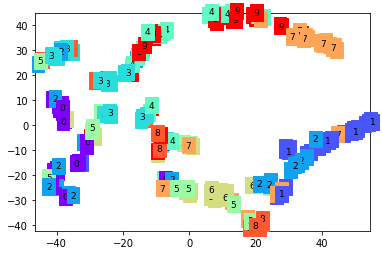

In [44]:
X = encoded_data.data.numpy()
X_embedded = TSNE(n_components=2, perplexity=5, init='pca', n_iter=1000).fit_transform(X)
X_embedded.shape

plot2D_with_labels(X_embedded, digits)

# T-SNE (from scratch)

## Meltpool

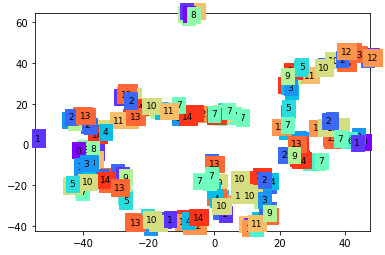

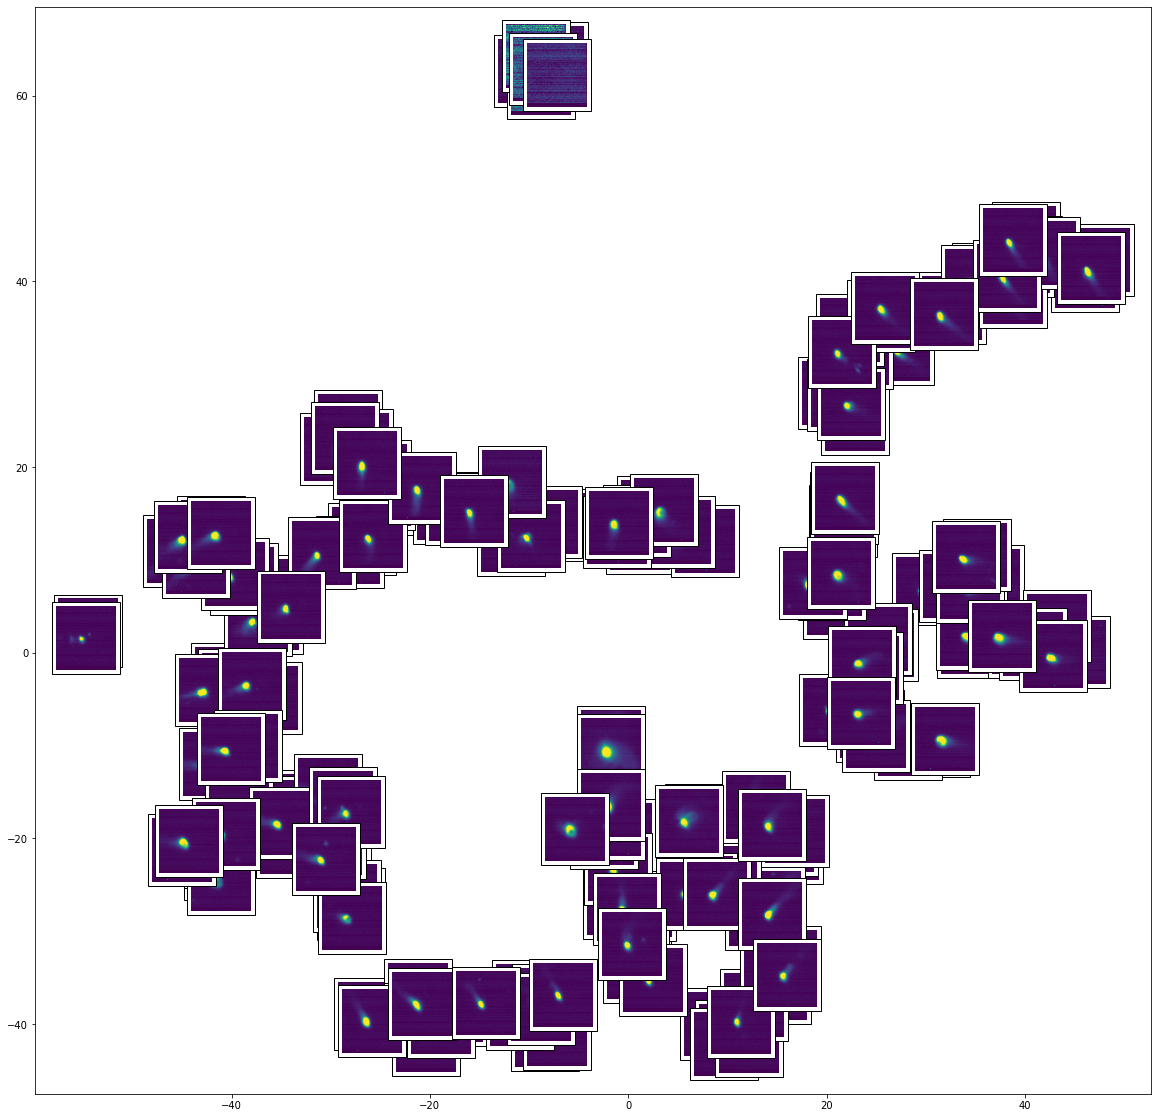

In [116]:
X = view_data # shape = (nsamples,nfeatures) = (200, 784)
X_embedded = TSNE(n_components=2, perplexity=5, init='pca', n_iter=1000).fit_transform(X)
X_embedded.shape
plot2D_with_labels(X_embedded, view_data_layers, num_labels = 15)
plot2D_with_thumbnails(X_embedded, view_data_layers, view_thumbnails, num_labels = 15)

## MNIST

In [41]:
X = view_data # shape = (nsamples,nfeatures) = (200, 784)
X_embedded = TSNE(n_components=2, perplexity=5, init='pca', n_iter=1000).fit_transform(X)
X_embedded.shape

(200, 2)

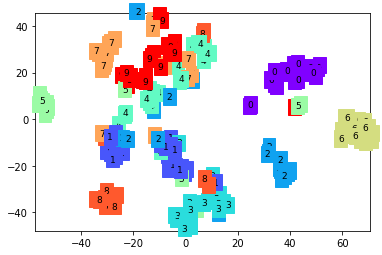

In [42]:
plot2D_with_labels(X_embedded, digits)